# $$Optimization~of~a~stopping~strategy$$

## Importations

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Basic Functions and Monte Carlo

We consider a stock whose daily prices are given by:

$$
S_{n+1} = S_n \exp \left( -\frac{1}{2} \sigma^2 \left(\Delta{t}\right) + \sigma \sqrt{\left(\Delta{t}\right)} \epsilon_{n+1} \right)
$$

where $S_{0}$ is given, $\Delta{t}$ = $\frac{1}{252}$, and $\epsilon_{n+1}$ for n $\geq 0$ are independent and identically distributed (i.i.d.) standard Gaussian variables.

We also define:

$$
A_n = \frac{S_0 + S_1 + \ldots + S_n}{n + 1}
$$

Creating a function for simulating stock price trajectories:

In [4]:
def simul_s(S0,sigma,dt,N,nb_traj,seed=42):

    """
    Function that simulates a given number of trajectories for a stock.


    ----------
    Parameters
    ----------

    S0 : initial value of the stock
    sigma : stock volatility
    dt : time delta
    N : number of increments
    nb_traj : number of trajectories to be simulated
    seed : random seed number
    """

    #Set random seed
    np.random.seed(seed)

    #Initialize trajectories matrix
    trajectories = np.zeros((nb_traj, N+1))

    #Initialize vector of Gaussian variables
    epsilons = np.random.normal(0,1, (nb_traj, N))
    
    #Define matrix of formulas to apply from one S to another
    formulas = np.exp(-0.5*(sigma**2)*dt + sigma*np.sqrt(dt)*epsilons)

    #Initialize S0
    trajectories[:, 0] = S0

    #Apply formulas as cumulative products
    trajectories[:, 1:] = S0 * np.cumprod(formulas, axis = 1)
    
    #Return trajectory values
    return trajectories    

Creating a function s_to_a(trajectories) that accepts an array of trajectories, as returned by simul_s, and computes an array of shape (nb_traj, N+1). This array contains nb_traj samples of An (where An is the running average) for each trajectory of Sn represented by the input trajectories:

In [5]:
def s_to_a(trajectories):

    """
    Function that takes array of trajectories as input and computes values of An

    
    ----------
    Parameters
    ----------

    trajectories : matrix of simulated trajectories of the stock value
    """

    #Compute cumulative sum of stock values for each trajectory
    cumsum_s = np.cumsum(trajectories, axis = 1)

    #Compute denominator for each value of A
    denominator = np.arange(1, trajectories.shape[1] + 1)

    #Compute value of An for each trajectory
    An = cumsum_s / denominator

    #Return values of An
    return An

Ploting a few graphs to check that the functions work:

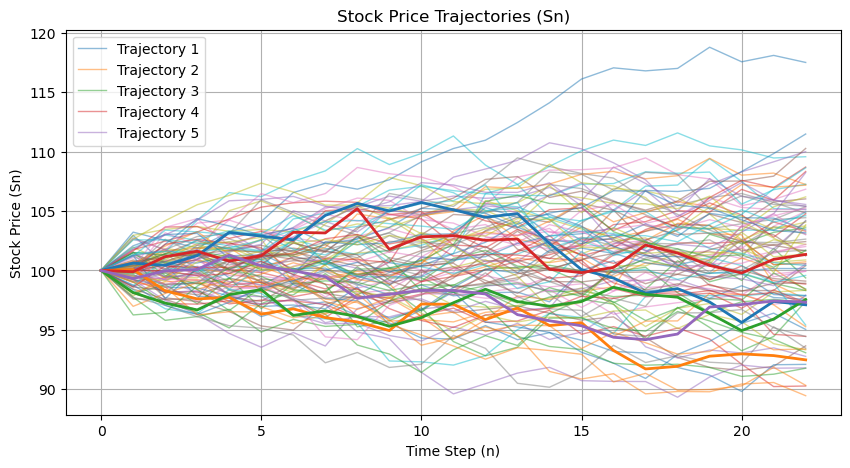

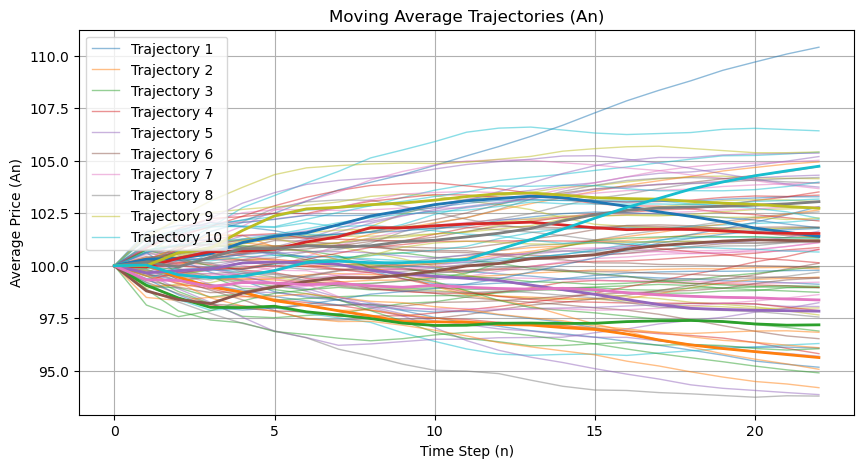

In [6]:
#Parameters for simulations
S0 = 100
sigma = 0.2
dt = 1/252
N = 22
nb_traj = 100
seed = 42


#Generate Sn trajectories
stock_trajectories = simul_s(S0, sigma, dt, N, nb_traj, seed)

#Calculate An values from Sn trajectories
An_values = s_to_a(stock_trajectories)

#Plot a few stock price trajectories (Sn)
plt.figure(figsize=(10, 5))
plt.plot(stock_trajectories.T, alpha=0.5, lw=1)

#Highlighting a few trajectories
plt.plot(stock_trajectories[:5].T, lw=2)

plt.title('Stock Price Trajectories (Sn)')
plt.xlabel('Time Step (n)')
plt.ylabel('Stock Price (Sn)')
plt.legend([f'Trajectory {i+1}' for i in range(5)])
plt.grid(True)
plt.show()

#Plot a few average price trajectories (An)
plt.figure(figsize=(10, 5))
plt.plot(An_values.T, alpha=0.5, lw=1)

#Highlighting a few trajectories
plt.plot(An_values[:10].T, lw=2)

plt.title('Moving Average Trajectories (An)')
plt.xlabel('Time Step (n)')
plt.ylabel('Average Price (An)')
plt.legend([f'Trajectory {i+1}' for i in range(10)])
plt.grid(True)
plt.show()

It can be noticed that the trajectories of the moving average are much smoother. Indeed, the moving average diminishes the short-term abrupt fluctuations that can appear in the trajectory of the stock value. We are now going to implement Monte Carlo simulation methods in order to obtain the expectation of the ratio A_N / S_N. We first start by a basic Monte Carlo implementation without any variance reduction techniques

Creating a function called montecarlo(trajectories) designed to operate on trajectories generated by simul_s. It approximates the expected value of E[An / Sn] using a Monte-Carlo method. Additionally, the function calculates and returns a confidence interval for the approximation.

In [7]:
def montecarlo(trajectories):

    """

    Function that returns the expectation of the ration An / Sn


    ----------
    Parameters
    ----------

    trajectories : matrix with simulated trajectories of the stock value
    
    """

    #Compute value An
    An = s_to_a(trajectories)[:, -1]

    #Obtain last simulated value of the stock
    Sn = trajectories[:, -1]

    #Compute empirical mean and standard deviation of ratios of An over last values of the stoc
    ratios = An/Sn
    expectation = ratios.mean()
    std_dev = ratios.std()

    #Compute 95% confidence interval
    std_error = std_dev / np.sqrt(len(ratios))
    interval_width = 1.96* std_error
    confidence_interval = (expectation - interval_width, expectation+interval_width)

    return expectation, confidence_interval

Application with S0 = 10, sigma = 0.2, dt = 1/252 and N = 22:

In [8]:
trajectory = simul_s(100, 0.2, 1/252, 22, 100, seed=42)
montecarlo(trajectory)

(0.9983455949247179, (0.9924371437516744, 1.0042540460977614))

The simulation of 100 stock trajectories gives a fair overall approximation of the ratio between A_N and S_N. We are now going to optimize the estimation by implementing several variance reduction techniques. The following represent some of the possible techniques which can be implemented :

- Antithetic variables
- Moment Matching
- Control Variates
- Importance Sampling 

$\textbf{Antithetic variables :}$ They represent variables that are negatively correlated with the variables of interest. The variables are implemented by using negative normally distributed standard random variables and hence changing the sign in the Black and Scholes formula.The ratios An / Sn obtained in the antithetic and initial case are averaged.

The method is implemented below. It can be noticed that we have a slight change in the expectation and a significant reduction in the width of the confidence interval. The method implemented made the prediction more precise.

In [9]:
#Antithetic variables
def simul_s_antithetic(S0,sigma,dt,N,nb_traj,seed=42):

    """
    Function that simulates a given number of trajectories for the antithetic stock.


    ----------
    Parameters
    ----------

    S0 : initial value of the stock
    sigma : stock volatility
    dt : time delta
    N : number of increments
    nb_traj : number of trajectories to be simulated
    seed : random seed number
    """

    #Set random seed
    np.random.seed(seed)

    #Initialize trajectories matrix
    trajectories = np.zeros((nb_traj, N+1))

    #Initialize vector of Gaussian variables
    epsilons = -np.random.normal(0,1, (nb_traj, N))
    
    #Define matrix of formulas to apply from one S to another
    formulas = np.exp(-0.5*sigma**2*dt + sigma*np.sqrt(dt)*epsilons)

    #Initialize S0
    trajectories[:, 0] = S0

    #Apply formulas as cumulative products
    trajectories[:, 1:] = S0 * np.cumprod(formulas, axis = 1)
    
    #Return trajectory values
    return trajectories    


def montecarlo_antithetic(S0, sigma, dt, N, nb_traj, seed = 42):

    """
    Function that computes the expectation and confidence intervals of the ratios An / Sn


    ----------
    Parameters
    ----------

    S0 : initial value of the stock
    sigma : stock volatility
    dt : time delta
    N : number of increments
    nb_traj : number of trajectories to be simulated
    seed : random seed number
    """


    np.random.seed(seed)

    #Generate initial and antithetic trajectories :
    initial_trajectory = simul_s(S0, sigma, dt, N, nb_traj, seed = 42)
    antithetic_trajectory = simul_s_antithetic(S0, sigma, dt, N, nb_traj, seed = 42)

    #Compute A_N for both trajectories
    A_matrix_original = s_to_a(initial_trajectory)
    A_matrix_antithetic = s_to_a(antithetic_trajectory)
    
    #Compute ratios for both trajectories
    ratios_original = A_matrix_original[:, -1] / initial_trajectory[:, -1]
    ratios_antithetic = A_matrix_antithetic[:, -1] / antithetic_trajectory[:, -1]
    
    #Average the ratios
    average_ratios = 0.5 * (ratios_original + ratios_antithetic)
    
    #Compute expectation and confidence interval
    expectation = average_ratios.mean()
    std_dev = average_ratios.std()
    std_error = std_dev / np.sqrt(len(average_ratios))
    interval_width = 1.96 * std_error
    confidence_interval = (expectation - interval_width, expectation + interval_width)
    
    return expectation, confidence_interval

montecarlo_antithetic(10, 0.2, 1/252, 22, 100)

(1.0016010321416504, (1.0014439656405172, 1.0017580986427836))

$\textbf{Control variates :}$ A control variate represents a random variable that is correlated with the variable of interest, having a known expectation. Samples of both the variable of interest and the control variate are generated and the mean of the variable of interest is adjusted taking into account the expectation of the control variate as well as the mean of its generated sample. This adjustment reduces the variances of the expectation estimate.

Given that the quantity of interest in our case is the ratio of An over Sn, we are looking for a variable that is correlated to the ratio. One choice can be simply Sn, since its value is correlated to the ratio. Below we find the application of this method, we can notice that the confidence interval has shrunken.

In [10]:
def montecarlo_control_variates(trajectories):
    
    #Compute value An
    An = s_to_a(trajectories)[:, -1]

    #Obtain last simulated value of the stock
    Sn = trajectories[:, -1]

    #Compute ratios of An over last values of the stock
    ratios = An / Sn

    #Use Sn as a control variate
    control_variate = Sn
    control_variate_mean = np.mean(control_variate)

    #Coefficient of adjustment
    beta = -np.cov(ratios, control_variate)[0, 1] / np.var(control_variate)
    
    # Adjust the ratios using the control variate
    ratios_adjusted = ratios + beta * (control_variate - control_variate_mean)

    # Compute empirical mean and standard deviation of adjusted ratios
    expectation = ratios_adjusted.mean()
    std_dev = ratios_adjusted.std()

    # Compute 95% confidence interval
    std_error = std_dev / np.sqrt(len(ratios_adjusted))
    interval_width = 1.96 * std_error
    confidence_interval = (expectation - interval_width, expectation + interval_width)

    return expectation, confidence_interval

Application of Monte Carlo simulation with control variates with S0 = 10, sigma = 0.2, dt = 1/252 and N = 22:

In [11]:
trajectory = simul_s(10, 0.2, 1/252, 22, 100, seed=42)
montecarlo_control_variates(trajectory)

(0.9983455949247179, (0.9951760968035864, 1.0015150930458492))

## Mathematical determination of the value of the above expectation: $ E[\frac{A_N}{S_N}] $

We consider : $$ S_{n+1} = S_n exp(-\frac{1}{2}\sigma^2\Delta t +\sigma \sqrt{\Delta t}\epsilon_{n+1}) $$ 
$$$$

$$ A_n = \frac{S_0+S_1+...+S_n}{n+1} $$

$S_0$ given,  ($\epsilon_{n+1})_{n\geq0}$  i.i.d. standard Gaussian variables.


$$ E[\frac{A_N}{S_N}] = \frac{1}{N+1} E[\frac{\sum_{i=0}^{N}S_i}{S_N}] 
= \frac{1}{N+1}\sum_{i=0}^{N}E[\frac{S_i}{S_N}] 
= \frac{1}{N+1}\sum_{i=0}^{N}E[\frac{S_i}{S_0\prod_{i=1}^{N}exp(-\frac{1}{2}\sigma^2\Delta t +\sigma \sqrt{\Delta t}\epsilon_{i})}]$$ 
$$$$
$$
= \frac{1}{N+1}( E[\frac{1}{\prod_{i=1}^{N}exp(-\frac{1}{2}\sigma^2\Delta t +\sigma \sqrt{\Delta t}\epsilon_{i})}] + E[\frac{1}{\prod_{i=2}^{N}exp(-\frac{1}{2}\sigma^2\Delta t +\sigma \sqrt{\Delta t}\epsilon_{i})}]+...+ 1 ] )$$

by independance of $\epsilon_i$  $$ = \frac{1}{N+1}(\prod_{i=1}^{N}E[exp(\frac{1}{2}\sigma^2\Delta t -\sigma \sqrt{\Delta t}\epsilon_{i})] +\prod_{i=2}^{N}E[exp(\frac{1}{2}\sigma^2\Delta t -\sigma \sqrt{\Delta t}\epsilon_{i})]+...+ 1])$$

since $\epsilon\sim \mathcal{N}(0, 1)$ $$ 
= \frac{1}{N+1} (exp(N(\frac{1}{2}\sigma^2\Delta t +\frac{1}{2}\sigma^2\Delta t))+exp((N-1)(\frac{1}{2}\sigma^2\Delta t +\frac{1}{2}\sigma^2\Delta t))+...+1) $$

so $$E[\frac{A_N}{S_N}] 
= \frac{1}{N+1} \sum_{i=0}^{N}exp(i(\sigma^2\Delta t))  
= \frac{1}{N+1} \frac{1-exp((N+1)(\sigma^2\Delta t))}{1-exp(\sigma^2\Delta t)}$$

Implementation of the obtained theoretical formula:

In [12]:
def math_question(N, sigma, dt):

    """
    Function that computes the expectation given the obtained theoretical formula.

    ----------
    Parameters
    ----------

    N : number of terms in the formula of moving average, minus 1
    sigma : stock volatility
    dt : time delta 
    """
    terms = np.exp(np.arange(N + 1) * sigma**2 * dt)
    result = (1 / (N + 1)) * np.sum(terms)
    return result

math_question(22, 0.2, 1/252)

1.0017481122115626

The implementation of the theoretical formula gives a slightly different result than the one obtained using Monte Carlo Simulations. Since Monte Carlo simulations rely on sampling for the computation of results, this slight difference can be attributed to this particular reason. Implementing Monte Carlo simulations with different values for the parameter 'seed' yielded different results, in some cases higher than the one obtained using the theoretical formula.

Cheking the code with the numerical application: S0 = 10, sigma = 0.2, dt = 1/252 and N = 22

In [13]:
trajectory = simul_s(10, 0.2, 1/252, 22, 100, seed=42)
montecarlo(trajectory)

(0.9983455949247179, (0.9924371437516744, 1.0042540460977614))

We can remark that thanks to the Law of Large numbers a higher numbers of simulation will give a result that is closer to the theoretical expectation, as will can notice below with a simulation of one million trajectories:

In [14]:
#Application with S0 = 10, sigma = 0.2, dt = 1/252 and N = 22
trajectory = simul_s(10, 0.2, 1/252, 22, 1000000, seed=42)
montecarlo(trajectory)

(1.0017715912465712, (1.0017052943249438, 1.0018378881681986))

## Strategy and Optimization

Let $a \geq 1$. We consider $\tau_a = \min(\min_{n \in \{0, \ldots, N\}} \{n \mid A_n \geq aS_n\}, N)$

The value of the stopping time $\tau_a$ represents the minimum index value n for which the ratio A_n / S_n passes above the threshold a. If the ratio is never above this value, the value of $\tau_a$ is then the last value of the index, N.

In [15]:
def strat_ratio(a, trajectories):
    """
    Function that approximates E(A_{τ_a} / S_{τ_a}) using a Monte-Carlo method.

    ----------
    Parameters
    ----------
    a : stopping time threshold
    trajectories : matrix of simulated trajectories of the stock value
    """

    #Compute value of An
    An = s_to_a(trajectories)

    #Compute stopping time τ_a
    condition = An >= a * trajectories

    #Find the index of the first True in each row of condition. If condition never met, use N
    tau_a = np.where(np.any(condition, axis=1), np.argmax(condition, axis=1), trajectories.shape[1] - 1)

    #Compute A_{τ_a} / S_{τ_a} for each trajectory
    ratio = An[np.arange(trajectories.shape[0]), tau_a] / trajectories[np.arange(trajectories.shape[0]), tau_a]

    #Return the average ratio
    return np.mean(ratio)

We are now looking to find the value of the threshold a that maximizes the given expectation. For this we are firstly using a recursive approach. The function below goes through a range of given value for a. It stops if all the possible values have been analyzed. Otherwise, it computes the corresponding output of strat_ratio and replaces the current value for the optimal a with the newly found one if the output of strat_ratio is higher than the previous one.

In [16]:
def argmax_a(a_values, trajectories, current_index=0, max_value=None, optimal_a=None):

    """"
    Function that finds the value of a that maximizes the output of the function strat_ratio


    ----------
    Parameters
    ----------

    a_values : range of values over which the function will search
    trajectories : simulated stock trajectories, which will be used as input for strat_ratio
    current_index : the index for a_values that is being processed
    max_value : current maximum value obtained for strat_ratio o
    optimal_a : the value of a that will correspond to max_value
    """

    #Case in which all values of a have been checked
    if current_index == len(a_values):
        return optimal_a

    #Calculate current value
    current_a = a_values[current_index]
    current_value = strat_ratio(current_a, trajectories)

    #If this is the first iteration, we initialize max_value and optimal_a
    if max_value is None or optimal_a is None:
        max_value = current_value
        optimal_a = current_a

    #Check if the current value is greater than the max_value
    if current_value > max_value:
        max_value = current_value
        optimal_a = current_a

    #Recursive call for the next element
    return argmax_a(a_values, trajectories, current_index + 1, max_value, optimal_a)

#Use the trajectories defined before
trajectories = stock_trajectories

#Define the range of values for a
a_values = np.linspace(1, 1.5, 2000)

#Find the optimal a using recursion
max_a = argmax_a(a_values, trajectories)

#Print the max_a
max_a

1.0120060030015008

We are now looking for an alternative optimization method for our expectation. In order to establish a proper choice of optimization algorithm, let us first take a look at the nature of the function and its behavior with respect to the value of the threshold a. We fix the set of trajectories.

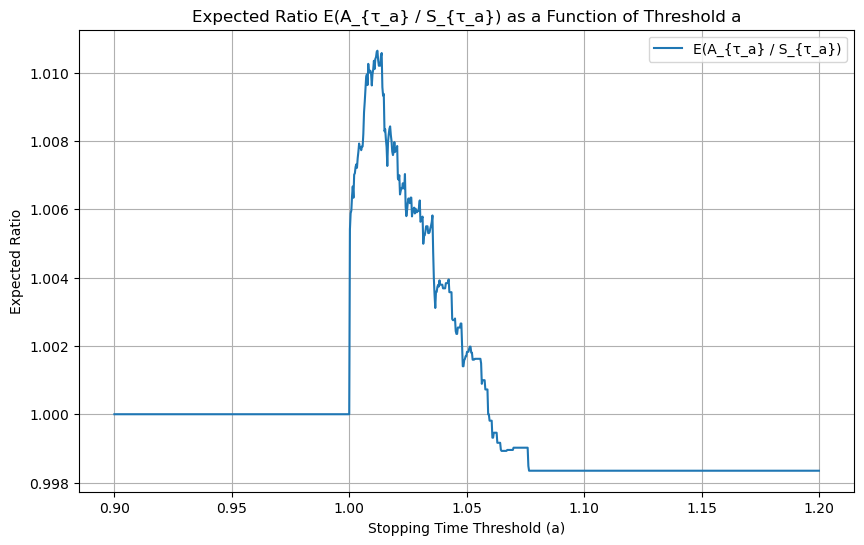

In [17]:
#Graph of the strat_ratio function with respect to different values of a for fixed trajectories

# Vectorize the strat_ratio function
vectorized_strat_ratio = np.vectorize(lambda a: strat_ratio(a, stock_trajectories))

# Range of a values to test
a_values = np.linspace(0.9, 1.2, 1000)

# Calculate the strat_ratio for each 'a'
ratios = vectorized_strat_ratio(a_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(a_values, ratios, label='E(A_{τ_a} / S_{τ_a})')
plt.xlabel('Stopping Time Threshold (a)')
plt.ylabel('Expected Ratio')
plt.title('Expected Ratio E(A_{τ_a} / S_{τ_a}) as a Function of Threshold a')
plt.legend()
plt.grid(True)
plt.show()


We observe that strat_ratio gives a rather noisy plot with numerous steps. The behavior of the function indicates that it may be not differentiable. The Nelder-Mead optimization method for minimization is adapted for this type of functions, as this approach does not rely on gradient information.

The method is based on the constrution of a simplex, which represents a geometrical construction in the space of parameters. The simplex updates its values step by step towards the direction of the minimum of the function, computing its output for each vertex in the simplex.The results obtained are ranked from best to worst, replacing afterwards the worst point obtained by the centroid if the result of the function is improved.

Given the graph, we can expect an optimal value for threshold a of approximately 1.012, which was the case for the value that was obtained before.

In [18]:
def argmax_a_NM(trajectory):
    
    """
    Function that uses scipy minimizer in order to minimize the negative of the expectation of the ratio and obtain the corresponding value of a

    ----------
    Parameters
    ----------

    trajectory : output of the function simul_s which will correspond to simulated stock trajectories

    """
    def negated_strat_ratio(a, trajectory):
        return -strat_ratio(a, trajectory)

    # Application of minimization using scipy
    result = minimize(negated_strat_ratio, x0=1., method='Nelder-Mead', args=(trajectory,), tol=1e-10)
    
    return result

#Use the trajectories defined before
trajectories = stock_trajectories

#Find the optimal a using Nelder-Mead method
max_a_NM = argmax_a_NM(trajectories)

#Print the max_a_NM
max_a_NM.x

array([1.0121582])

We can notice that we found approximatively the same "a" than previously. With this "a" we will find the maximum function value.

Numerical applications:

Applying the two methods that return the maximum value of the function.

In [19]:
#Numerical application of the first method with S0 = 10, sigma = 0.2, dt = 1/252 and N = 22
trajectories = simul_s(10,0.2,1/252,22,100,seed=42)
strat_ratio(max_a, trajectories)

1.0106449055868914

In [20]:
#Numerical application of the Nelder-Mead method with S0 = 10, sigma = 0.2, dt = 1/252 and N = 22
trajectories = simul_s(10,0.2,1/252,22,100,seed=42)
strat_ratio(max_a_NM.x, trajectories)

1.0106727230055588

The both results concords with the graph.